In [47]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df_train_original = pd.read_csv(r"C:\Users\luis_\Documents\GitHub\data-science-projects\house-price-prediction\train.csv")
df_test_original = pd.read_csv(r"C:\Users\luis_\Documents\GitHub\data-science-projects\house-price-prediction\test.csv")

In [5]:
# Creating Duplicate Dataframe 
df_train = df_train_original.copy()
df_test = df_test_original.copy()

## Problem Description

The objective of this project is simply to create predictive models using any library available in Python. I opted to use the [Kaggle House Prices Competition Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) since the dataset is readily available, does not require too much cleaning/wrangling, and predictions can be evaluated on the competition leaderboard.

The House Price Competition contains 2 datasets, Train and Test. The training dataset includes 1 dependent variable (SalesPrice), and 79 explanatory variables from which to predict SalesPrice. The Test dataset contains just the 79 explanatory variables. My task was to make the best predictions possible on houses in the Test dataset.

This notebook demonstrates the following approach:

- Data wrangling (Light exploration, followed by removing and transforming some variables)
- Splitting the training dataset into training and validation datasets.
- Fitting a model using a Scikit-Learn pipeline (Data Preprocessing + Randomized Search across 2 estimators and their respective hyperparameters)
- Evaluating model performance, then trying an automated approach to selecting hyperparameters.
- Making predictions.

## Visualising the Dependent Variable (SalePrice)

The SalePrice variable actually has quite a strong positive skew, but there are still a lot of houses that sold at least 2x above the mode.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

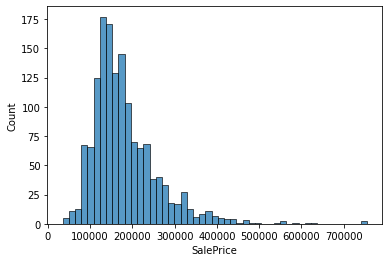

In [6]:
import seaborn as sns
sns.histplot(data=df_train, x="SalePrice")

## Data Wrangling

### Removing Id Column
The Id column simply identifies the row in the dataset and has no predictive power.

In [7]:
df_train = df_train.drop(columns="Id")

### Checking Datatypes

The "MSSubClass" category uses integers to specify types of dwelling, but these integers simply refer to categories.
I will change the datatype of this column from int to str.

In [8]:
# Transformation 1: int > str
df_train["MSSubClass"] = df_train["MSSubClass"].astype("str")

# Apply same to df_test
df_test["MSSubClass"] = df_test["MSSubClass"].astype("str")

dtype('O')

### Checking missing values

There are a few variables with many missing values. However, I will include these variables since I'll be using decision tree algorithms, which are robust against missing values.
(Side note: I tried removing all variables with over 30% missing values, but the accuracy of predictions deteriorated)

In [9]:
df_train.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
dtype: int64

### Checking Variable Distribution

Checking wildly skewed columns for variables that can be removed or transformed. Pandas offers a skew method, which implements [Scipy's skew](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) method with bias set to False.

#### Log Transform

In Machine Learning algorithms, the distribution of a variable can have a large effect on its usefulness. For heavily skewed variables (as in the image below), potentially important information can be lost in lower value ranges, since higher values are messing up the scale and cause lower values to be banded closely together. In this case, a log transform opens up the space between values by readjusting the scale, making it easier for an algorithm to understand how small differences in dependent variables affect the independent variable (and vice versa). 

<img src="./log_transform.png" width="400">

In [10]:
df_train.select_dtypes(include=["int64","float64"]).skew().sort_values(ascending=False).head(10)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
dtype: float64

#### Removing Variables with mostly 0 values

Checking histograms of all highly skewed variables. MiscVal, LowQualFinSF, 3SsnPorch and Pool Area all have just a handful of values that are not 0, but the remaining values could be quite predictive.
I removed these variables to see if predictions would improve, but they actually become less accurate.

LotArea has values that span across 2 orders of magnitude. I'd like to keep that information, so I will log transform the variable.

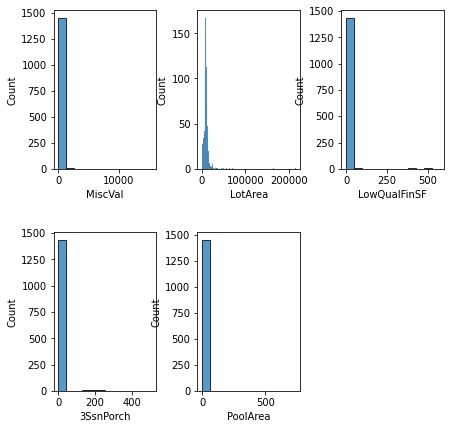

In [11]:
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 3, 1)
sns.histplot(data=df_train, x="MiscVal", ax=ax)
ax = fig.add_subplot(2, 3, 2)
sns.histplot(data=df_train, x="LotArea", ax=ax)
ax = fig.add_subplot(2, 3, 3)
sns.histplot(data=df_train, x="LowQualFinSF", ax=ax)
ax = fig.add_subplot(2, 3, 4)
sns.histplot(data=df_train, x="3SsnPorch", ax=ax)
ax = fig.add_subplot(2, 3, 5)
sns.histplot(data=df_train, x="PoolArea", ax=ax)

plt.show()

In [12]:
df_train['LotArea'] = np.log(df_train['LotArea'])
df_test['LotArea'] = np.log(df_test['LotArea'])

### Removing Variables with High Multicollinearity
Keeping sets of variables that correlate strongly with each other can contribute to overfitting, so I will discover and remove these.
Below is a correlation matrix of all numerical variables.

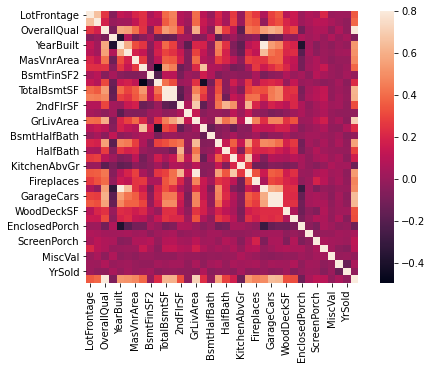

In [13]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

Below is a table of all variable pairs with a correlation coefficient above 0.7 or below -0.7. I want to keep the variables that are highly correlated with SalePrice, so they will stay. 
I will remove the following variables: GarageYrBlt, TotalBsmtSF, TotRmsAbvGrd, GarageCars.

In [14]:
# Remove one variable in variable pairs where the correlation coefficient is above 0.7
threshold = 0.7
mask = corrmat.abs() > threshold
mask_2 = corrmat.abs() < 1
corrmat.where(mask & mask_2).stack()

OverallQual   SalePrice       0.790982
YearBuilt     GarageYrBlt     0.825667
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
              SalePrice       0.708624
TotRmsAbvGrd  GrLivArea       0.825489
GarageYrBlt   YearBuilt       0.825667
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
SalePrice     OverallQual     0.790982
              GrLivArea       0.708624
dtype: float64

In [15]:
df_train = df_train.drop(columns=['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars'])

## Data Preprocessing
After going through a more manual process of preparing data, there are still a few steps to take across all numerical and categorical variables.

### Numerical values
- Impute missing values using the median value of the column.
- Standardize the scale of each variable by removing the mean and scaling to unit variance (variance = 1).

In [16]:
# preprocessing for numeric columns
imp_median = SimpleImputer(strategy="median", add_indicator=True)
scaler = StandardScaler()

### Categorical variables

- Impute a "missing_value" string where values are missing.
- One hot encode all categorical variables.

In [17]:
# preprocessing for categorical columns
imp_constant = SimpleImputer(strategy="constant")
ohe = OneHotEncoder(handle_unknown="ignore")

### Create pipeline

Separate numerical and categorical variables, create pipeline to implement steps defined in preprocessing.

In [18]:
# select columns by data type
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

In [19]:
# all preprocessing
preprocessor = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols))

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([('preprocessing', preprocessor), ('clf', RandomForestRegressor())])

## Split "train" dataset into train, valid datasets
The following step splits the training dataset into training and validation datasets at a ratio of 8:2.

In [21]:
# Define X (independent variables) and y (dependent variable)
X = df_train.drop(columns="SalePrice")
y = df_train["SalePrice"]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)

## Setting a baseline before optimization

In [22]:
pipe.fit(X_train, y_train)
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Validation set score: ' + str(pipe.score(X_valid,y_valid)))

Training set score: 0.9798695106661942
Validation set score: 0.8838037954682341


## Feature Engineering

### "SalesPrice" distribution
As noted previously, the target variable "SalesPrice" has a strong positive skew. In this case, this can be interpreted as there being large absolute value differences in more expensive house prices. These larger differences are likely to lead to overfitting, as the model attributes specific weights to explanatory variables to explain specific house prices.

Taking a log transform of SalePrice reduces the distance between more expensive prices, so the model is less rigid and can better generalize when presented with new data.
The following code creates a duplicate dataframe with the log-transformed dependent variable and displays a plot to see how the distribution has changed. I then ran two basic Random Forest Regression models with and without the log transform to see if there is any effect. The log-transformed "SalesPrice" resulted in better predictions on the validation set. 

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

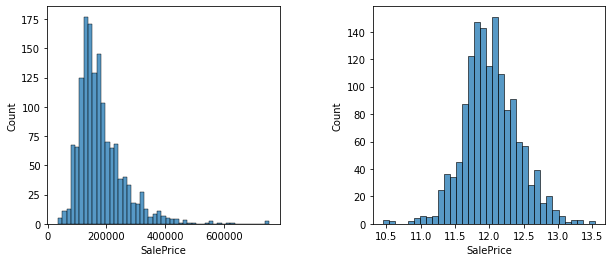

In [23]:
df_train_fe = df_train.copy()

# Log transform
df_train_fe["SalePrice"] = np.log(df_train_fe["SalePrice"])

fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
sns.histplot(data=df_train, x="SalePrice", ax=ax)
ax = fig.add_subplot(1, 2, 2)
sns.histplot(data=df_train_fe, x="SalePrice", ax=ax)

In [24]:
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Validation set score: ' + str(pipe.score(X_valid,y_valid)))

X_fe = df_train_fe.drop(columns="SalePrice")
y_fe = df_train_fe["SalePrice"]

from sklearn.model_selection import train_test_split
X_train_fe, X_valid_fe, y_train_fe, y_valid_fe = train_test_split(X_fe,y_fe, test_size=0.2)

pipe_fe = pipe
pipe_fe.fit(X_train_fe, y_train_fe)

print('Training set score with a log-transformed SalePrice: ' + str(pipe.score(X_train_fe,y_train_fe)))
print('Validation set score with a log-transformed SalePrice: ' + str(pipe.score(X_valid_fe,y_valid_fe)))

Training set score: 0.9798695106661942
Validation set score: 0.8838037954682341
Training set score with a log-transformed SalePrice: 0.9813993455371606
Validation set score with a log-transformed SalePrice: 0.8876042396441829


## Search Hyperparameters using RandomizedSearchCV

Next, I will create two models using XGBoost, and LightGBM.

Both of these algorithms make use of decision trees. Decision Trees split data by asking questions about each column of independent variables, then judging how predictive each split of values in each column ends up being on the column being predicted. The [StatQuest video on Decision Trees](https://www.youtube.com/watch?v=_L39rN6gz7Y) is a great introduction.

**Random Forest** - Theoretically, a single decision tree could be created that makes exact predictions on the training set by finely splitting each independent variable until it perfectly predicts the dependent variable. Since just small changes to the indepedent variables would result in completely different decision trees, a single decision tree would be unlikely to generalize well to new data. This is known as overfitting, and the model itself it said to have high variance. The Random Forest algorithm builds multiple decision trees, and merges them together to get a more accurate and stable prediction. Merging the predictions of many trees lowers the variance of the model and makes the resulting ensemble model more generalizable, a process known as "Bagging".

A line of best fit with high variance is shown below.

<img src="./random_forest_high_variance.png" width="400">

Source: Wade, Corey. Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python (p.84).

**XGBoost** - While a model with high variance will not generalize well, a model that just cuts a straight line will simply not make good predictions. Such a model is said to have high bias, as shown below.

<img src="./high_bias.png" width="400">

Source: Wade, Corey. Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python (p.83).

While bagging reduces variance by combining the predictions of multiple decision trees, boosting uses the error from these trees to inform models with new trees. XGBoost specifically uses gradient boosting, in which the residuals of each trees predictions are summed, and this sum is used to score the model.

Since the resulting predictions will be greatly influenced by the number of trees (estimators) created and how much each new tree learns from previously constructed trees, the n_estimators and learning rate hyperparameters are perhaps the two most important hyperparameters to tune.

**LightGBM** - Similiar to XGBoost, LightGBM also uses a combination of bagging and boosting to combine multiple tree estimators. The fundamental difference between the two is that XGBoost expands trees *level-wise*, while LightGBM expands trees *leaf-wise*. In the following images, black nodes represent inexpandable leaves, while green nodes represent leaves that can be be further split to grow the tree.

<img src="./level-wise.png" width="400">

<img src="./leaf-wise.png" width="400">

Source: [XGBoost vs LightGBM: How Are They Different](https://neptune.ai/blog/xgboost-vs-lightgbm)

Since XGBoost builds decision trees level-by-level, and each level includes more than one column, there is less chance of overfitting by splitting the training data down to specific values in specific columns relative to LightGBM. However, by growing *leaf-wise*, LightGBM can very quickly generate highly accurate models. To control for overfitting, both the XGBoost and LightGBM algorithms have a "max_depth" hyperparameter, which refers to the upper bound of layers in a single decision tree estimator. The LightGBM algorithm typically requires a lower max_depth than XGBoost.

In [25]:
import xgboost as xgb
import lightgbm as lgb

In [26]:
search_space_random = [
    {
        'clf': (xgb.XGBRegressor(), ),
        'clf__n_estimators': np.arange(100,1001,100),
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__max_depth': np.arange(1,151,10)
    },
    {
        'clf': (lgb.LGBMRegressor(), ),
        'clf__n_estimators': np.arange(100,1001,100),
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__max_depth': np.arange(1,50,5)
    }
]

In [27]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(pipe, search_space_random, cv=5, n_jobs=8, error_score="raise")

In [28]:
random_search.fit(X_train_fe,y_train_fe)
print('Training set score: ' + str(random_search.score(X_train_fe,y_train_fe)))
print('Validation set score: ' + str(random_search.score(X_valid_fe,y_valid_fe)))

Training set score: 0.9999395982541861
Validation set score: 0.9003712415140622


In [29]:
best_params = random_search.best_params_
print(best_params)

{'clf__n_estimators': 700, 'clf__max_depth': 31, 'clf__learning_rate': 0.1, 'clf': LGBMRegressor(max_depth=31, n_estimators=700)}


## Analyze the results
The following plots show the mean test scores for different hyperparameter values. In a typical flow for this kind of project, I would use this to determine the next iteration of the hyperparameter search space. However, this time I decided to take a different approach. 

In [30]:
result_df = pd.DataFrame.from_dict(random_search.cv_results_, orient='columns')

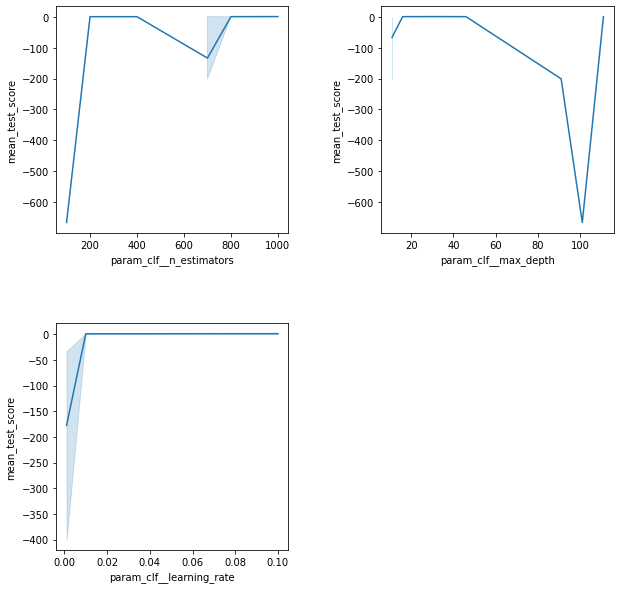

In [32]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=result_df, x='param_clf__n_estimators', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(data=result_df, x='param_clf__max_depth', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=result_df, x='param_clf__learning_rate', y='mean_test_score', ax=ax)

plt.show()

## Automated Hyperparameter Tuning with HyperOpt

To understand this process, I used [these lecture notes](https://www.cs.cornell.edu/courses/cs4787/2019sp/notes/lecture16.pdf) from a CS course at Cornell.

While my initial approach to tuning model hyperparameters was to visualize accuracy differences for different hyperparameter values and conduct another grid/random search on that basis, another method is to automate the process entirely using HyperOpt, which applies Bayesian optimization to the hyperparameter selection process.

Bayes Theorem can be used to work out the conditional probability of an outcome based on previous outcomes. If we want to optimize a function f(x) where x is any real number, we can model f as a probability distribution. We can then compute f at various values of x to get observed instances of x and, since f is defined as a probability distribution, we can infer f at unobserved instances of x. In the case of hyperparameter optimization, we follow the above process by modelling the hyperparameter as function f(x).

Encoding the probability distribution of f based on observed instances is typically done using a Gaussian Process prior. In essence, the probability distribution is modelled as a multivariate Gaussian distribution, and taking a sample of values for x will converge to the true mean and variance of x due to Central Limit Theorem (an extension of which shows that it can also apply to  multidimensional Gaussian distributions).

Finally, choosing the value of x to evaluate next requires a separate "acquisition function". There are a few ways to do this, but some popular approaches include:
- Probability of Improvement Function
    - Maximize the probability that the next value of x will be the best found so far.
- Expected Improvement
    - Minimize the expected improvement in f(x) AFTER the next x is observed.
- Lower Confidence Bound
    - Minimize Regret over optimization sequence.

In [33]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error

In [34]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.001, 0.31, 0.01)),
    'max_depth':        hp.choice('max_depth',        np.arange(1,151,10)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.choice('subsample', np.arange(0.8, 1, 0.05)),
    'n_estimators':     hp.choice('n_estimators',    np.arange(100,1001,100))
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.001, 0.31, 0.01)),
    'max_depth':        hp.choice('max_depth',        np.arange(1,151,10)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.choice('subsample', np.arange(0.8, 1, 0.05)),
    'n_estimators':     hp.choice('n_estimators',    np.arange(100,1001,100))
}

lgb_fit_params = {
    'eval_metric': 'rmse',
    'verbose' : False
    #'early_stopping_rounds': 10
}

lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [35]:
import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        hyperparams = space_eval(space, result)
        # Not currently returning trials
        return hyperparams

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [36]:
X_train_fe_processed = pipe_fe[0].fit_transform(X_train_fe)
X_valid_fe_processed = pipe_fe[0].transform(X_valid_fe)

In [37]:
obj = HPOpt(X_train_fe_processed, X_valid_fe_processed, y_train_fe, y_valid_fe)

In [44]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=300)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=300)

100%|██████████| 300/300 [02:47<00:00,  1.79trial/s, best loss: 0.10601293292575376]


The model with the minimum loss on the validation set turned out to be LightGBM, the optimal hyperparameters listed below.

In [39]:
lgb_opt

{'fit_params': {'eval_metric': 'rmse', 'verbose': False},
 'loss_func': <function __main__.<lambda>(y, pred)>,
 'reg_params': {'colsample_bytree': 0.4,
  'learning_rate': 0.030999999999999996,
  'max_depth': 81,
  'min_child_weight': 3,
  'n_estimators': 300,
  'subsample': 0.8500000000000001}}

In [40]:
pipe_hyperopt_lgb = Pipeline([('preprocessing', preprocessor), ('clf', lgb.LGBMRegressor(**lgb_opt['reg_params']))])

In [41]:
pipe_hyperopt_lgb.fit(X_train_fe, y_train_fe)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024503899E48>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='constant')),
                                                  

## Make Predictions

After a long process of data wrangling and model selection, I can finally make some predictions. First of all, some columns were deleted in the training set that still exist in the test set, so these need to be removed.

In [42]:
# Find different columns between dataframes
list(set(df_train_original.columns) - set(df_train.columns))

# Define X_test
X_test = df_test.drop(columns=list(set(df_train_original.columns) - set(df_train.columns)))

Next, I will use the LightGBM pipeline to make predictions. Since I earlier log transformed the independent variable, I'll need to take the exponent to switch it back to its original unit. 

In [43]:
predictions = pipe_hyperopt_lgb.predict(X_test)

d = {"Id":df_test["Id"],"SalePrice":predictions}
submission = pd.DataFrame(data=d)

# Revert log transform
submission["SalePrice"] = np.exp(submission["SalePrice"])

# Save CSV of predictions to submit to Kaggle
submission.to_csv("submission.csv",index=False)

submission

,Id,SalePrice
0,1461,124171.172634
1,1462,156513.805742
2,1463,184823.153659
3,1464,188010.058336
4,1465,187535.093457
...,...,...
1454,2915,81917.402405
1455,2916,83676.399601
1456,2917,162049.743389
1457,2918,111670.708911


That's it! At the time of posting, this submission placed 883rd of 5,053 teams on the Kaggle House Prices Leaderboard.

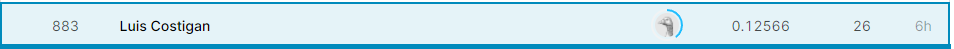